In [37]:
import matplotlib.pyplot as plt
import numpy as np
# Load MNIST dataset
train_images=np.load('/content/drive/MyDrive/datasets/mnist.npz (Unzipped Files)/x_train.npy')
train_labels=np.load('/content/drive/MyDrive/datasets/mnist.npz (Unzipped Files)/y_train.npy')
test_images=np.load('/content/drive/MyDrive/datasets/mnist.npz (Unzipped Files)/x_test.npy')
test_labels=np.load('/content/drive/MyDrive/datasets/mnist.npz (Unzipped Files)/y_test.npy')

In [38]:
data=[]
val_data=[]
val_lab=[]
print(train_images.shape)
lab=[]

print(len(train_labels[train_labels==0]))

data.extend(train_images[train_labels==0][1000:])

val_data.extend(train_images[train_labels==0][:1000])

data.extend(train_images[train_labels == 1][1000:])

val_data.extend(train_images[train_labels==1][:1000])

lab=[-1,]*(len(train_labels[train_labels==0])-1000) + [1,]*(len(train_labels[train_labels==1])-1000)

val_lab=[-1,]*1000+[1,]*1000

lab=np.array(lab)
val_lab=np.array(val_lab)
data=np.array(data)
val_data=np.array(val_data)
data=data.reshape(-1,784)
val_data=val_data.reshape(-1,784)
N=data.shape[0]
data=data.T
print(data.shape)

def pca(data,N):
  mean=np.mean(data,axis=1, keepdims=True)

  print(mean.shape)
  data=data-(mean)
  cov=(1/(N-1))*np.dot(data,data.T)
  print(N)
  eg_value,eg_vector=np.linalg.eigh(cov)

  eg=[]
  eg_vector=eg_vector.T
  for i in range(len(eg_value)):
    eg.append((eg_value[i],eg_vector[i]))

  sorted_keys=sorted(eg, key=lambda x: x[0])[::-1]
  sk2=sorted_keys[:10]
  print([i[0] for i in sk2])
  print(sorted_keys[0][0])
  U=[]
  # print(len(sorted_keys))
  for i,j in sorted_keys:
    U.append(j)
  U=np.array(U)
  Up=U[:5]
  y=np.dot(Up,data)
  return Up,mean,data
Up,mean,data=pca(data,N)
y=np.dot(Up,data)
yT=y.T
print(y.shape)
val_data=val_data.T-mean
val_data=np.dot(Up,val_data)
val_data=val_data.T
print(val_data.shape)
print(len(lab))

(60000, 28, 28)
5923
(784, 10665)
(784, 1)
10665
[1022953.1111329617, 291427.0654548821, 257647.89454930546, 178110.0102305892, 125004.85492479337, 110234.36273673267, 74999.92116921129, 66351.32837079643, 56676.978187646266, 50502.96997191876]
1022953.1111329617
(5, 10665)
(2000, 5)
10665


In [4]:

midpts=[]
classifies=[[],[],[],[],[]]
for i in range(5):
  values=sorted(list(set(y[i])))
  print(values[0],values[10000])
  mdpt=[]
  for j in range(len(values)-1):
    mdpt.append((values[j]+values[j+1])/2)

  midpts.append(mdpt)




-2330.829760860835 1026.9189901497386
-1547.143524140316 767.1234461053083
-1419.4462227153772 786.9577292489987
-1355.5844903029827 690.4446217535855
-930.528992293562 553.7183178876256


In [5]:
print(midpts[0][0],midpts[0][-1])

-2329.0166017597985 1139.1872893659684


In [6]:
for i in range(5):
  values=sorted([(yT[j][i],j) for j in range(len(lab))], key=lambda x: x[0])
  a=0
  b=0
  classify={1:[],-1:[]}
  classifies1=[]
  while(a<len(values) and b<len(midpts[i])):
    if values[a][0]<midpts[i][b]:
      classify[lab[values[a][1]]].append(values[a][1])
      a+=1
    else:
      classify[1]=np.array(classify[1])
      classify[-1]=np.array(classify[-1])
      classifies1.append(classify)
      classify={1:[j for j in classify[1]],-1:[j for j in classify[-1]]}
      b+=1
  while(b<len(midpts[i])):
    classify[1]=np.array(classify[1])
    classify[-1]=np.array(classify[-1])
    classifies1.append(classify)
    b+=1
  classifies2=[]
  a=len(values)-1
  b=len(midpts[i])-1
  classify={1:[],-1:[]}
  while(a>=0 and b>=0):
    if values[a][0]>=midpts[i][b]:
      classify[lab[values[a][1]]].append(values[a][1])
      a-=1
    else:
      classify[1]=np.array(classify[1])
      classify[-1]=np.array(classify[-1])
      classifies2.append(classify)
      classify={1:[j for j in classify[1]],-1:[j for j in classify[-1]]}
      b-=1
  while(b>=0):
    classify[1]=np.array(classify[1])
    classify[-1]=np.array(classify[-1])
    classifies2.append(classify)
    b-=1
  classifies2=classifies2[::-1]
  classifies[i]=[(classifies1[j],classifies2[j]) for j in range(len(classifies1))]




In [41]:
idx=-1
for i in range(len(midpts[0])):
  if(midpts[0][i]<-586):
    idx=i
print(midpts[0][idx])
print(len(classifies[0][idx][0][1])+len(classifies[0][idx][0][-1]))

-586.0838693866485
4083


In [7]:
w=[1/(len(lab)),]*len(lab)
w=np.array(w)
print(classifies[0][0],classifies[0][5000])
print(y.shape)
def boost(yT,w,splits,midpts,lab):
  # print(set(w))
  min_l=[np.inf,0,0,0,0]
  for i in range(5):
    for j in range(len(midpts[i])):
      classify=classifies[i][j]

      p=1 if len(classify[0][1])>len(classify[0][-1]) else -1
      q=1 if len(classify[1][1])>len(classify[1][-1]) else -1

      miss= 0 if len(classify[1][(-1)*q])==0  else np.sum(w[classify[1][(-1)*q]])
      miss+=0 if len(classify[0][(-1)*p])==0  else np.sum(w[classify[0][(-1)*p]])
      l=miss/np.sum(w)
      # print(l)
      if l<min_l[0]:
        min_l=[l,i,midpts[i][j],p,q]
  alpha=(1-min_l[0])/min_l[0]
  # print(alpha)

  dim,cut,p,q=min_l[1:]
  cnt=0

  for i in range(len(lab)):
    # print(len(lab),dim,i,yT.shape)
    if (yT[i][dim]>=cut  and lab[i]!=q) or (yT[i][dim]<cut  and lab[i]!=p):
      cnt+=1
      w[i] =w[i]*alpha
  # print(cnt,len(w),set(w))
  min_l.append(alpha)
  splits.append(min_l[1:])
splits=[]
for i in range(300):
  # print(i)
  # print(set(w))
  boost(yT,w,splits,midpts,lab)
  print(splits[-1])









({1: array([], dtype=float64), -1: array([1497])}, {1: array([9434, 6663, 8012, ..., 7274, 5915, 9669]), -1: array([1786, 1094, 2707, ..., 3201, 3617, 1263])}) ({1: array([ 9669,  5915,  7274,  6935,  7375,  5144,  7476,  5159,  6657,
        6701,  9858,  6241,  7590,  9660,  4934,  5634,  6204,  6386,
        7286,  6944,  8128,  7821,  5868,  5713,  5641,  7875,  7408,
        7671,  7718,  7944,  8433,  7489,  6274,  6431,  8462,  9641,
        8225,  8934,  6182,  8600,  6871,  7244,  8114, 10220,  7483,
        5577,  9759,  5411, 10165,  8555,  9747,  9897,  9165,  6462,
       10253,  8239,  6886,  5621,  6062,  6117,  7572,  6049,  8159,
       10596,  7887,  6487,  7747,  8631,  4972,  5698,  5779, 10085,
        8694,  7174,  8121,  9103,  7706,  6731,  8984,  6843,  8177,
        6547,  9543, 10458]), -1: array([1497, 1263, 3617, ..., 2783, 1734, 4793])}, {1: array([9434, 6663, 8012, ..., 5391, 9937, 6903]), -1: array([1786, 1094, 2707, 2954, 1480,  608])})
(5, 10665)
[0, 1

In [8]:
print(splits)

[[0, 189.85586681021456, -1, 1, 212.29999999999995], [0, 636.8268391112347, -1, 1, 3.235326976020429], [0, -295.9743906129746, -1, 1, 4.226024748646559], [1, 250.43837259952363, -1, 1, 3.3682011664639333], [2, 275.66982491609133, 1, -1, 3.1384199326526967], [3, -143.08216500548002, -1, 1, 1.9816239351439582], [0, -295.9743906129746, -1, 1, 2.339248181430008], [0, 636.8268391112347, -1, 1, 2.610007745239196], [0, -295.9743906129746, -1, 1, 1.8919691362781383], [1, 479.248000404853, -1, 1, 2.301148046010842], [0, -295.9743906129746, -1, 1, 1.7718669154092062], [2, 131.6304096953083, 1, -1, 1.5878993245853046], [1, 554.1297941552319, -1, 1, 1.6551791821338586], [0, -171.12288564608437, -1, 1, 1.55501876171994], [1, 173.55860515494135, -1, 1, 1.5201835940007358], [2, 347.92273686049975, 1, -1, 1.4219251379887927], [0, 636.8268391112347, -1, 1, 1.4324495473584378], [2, -497.88063783599574, -1, 1, 1.5406395240298498], [0, 636.8268391112347, -1, 1, 1.4255932562777045], [0, -295.9743906129746,

0.9975 65


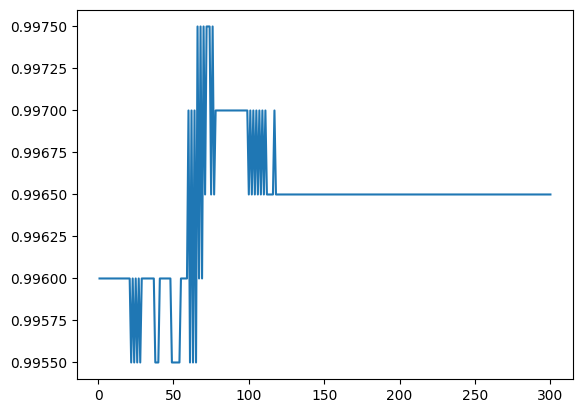

In [10]:
best_tree_split=[]
corrects=[0,]*300
for i in range(len(val_lab)):
  g=0
  for j in range(300):
    dim,cut,p,q,alpha=splits[j]
    alpha=np.log(alpha)
    if(val_data[i][dim]<=cut):
      g+=alpha*p
    else:
      g+=alpha*q
    pred=np.sign(g)
    if pred==val_lab[i]:
      corrects[j]+=1
plt_y=[corrects[i]/len(val_lab) for i in range(300) ]
plt_x=[i+1 for i in range(300)]

max_accu=0
max_idx=-1
for i in range(len(plt_y)):
  if max_accu<plt_y[i]:
    max_idx=i
    max_accu=plt_y[i]
print(max_accu,max_idx)

plt.plot(np.array(plt_x), np.array(plt_y))
plt.show()

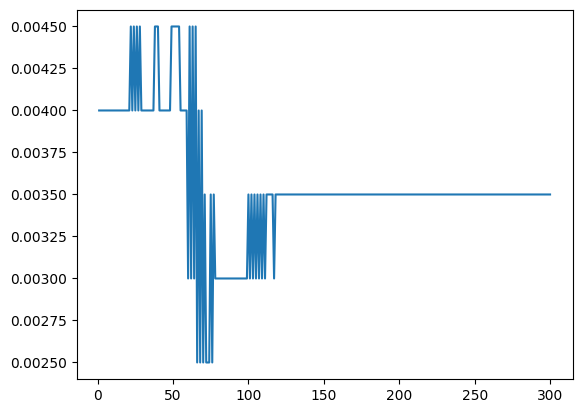

In [11]:
plt_y=[1-i for i in plt_y]
plt.plot(np.array(plt_x), np.array(plt_y))

In [ ]:
best_tree_split=[]
corrects=[0,]*300
for i in range(len(val_lab)):
  g=0
  for j in range(300):
    dim,cut,p,q,alpha=splits[j]
    alpha=np.log(alpha)
    if(val_data[i][dim]<=cut):
      g+=alpha*p
    else:
      g+=alpha*q
    pred=np.sign(g)
    if pred==val_lab[i]:
      corrects[j]+=1
plt_y=[corrects[i]/len(val_lab) for i in range(300) ]
plt_x=[i+1 for i in range(300)]

max_accu=0
max_idx=-1
for i in range(len(plt_y)):
  if max_accu<plt_y[i]:
    max_idx=i
    max_accu=plt_y[i]
print(max_accu,max_idx)

plt.plot(np.array(plt_x), np.array(plt_y))
plt.show()

In [39]:
splits2=[[0, 189.85586681021456, -1, 1, 212.29999999999995], [0, 636.8268391112347, -1, 1, 3.235326976020429], [0, -295.9743906129746, -1, 1, 4.226024748646559], [1, 250.43837259952363, -1, 1, 3.3682011664639333], [2, 275.66982491609133, 1, -1, 3.1384199326526967], [3, -143.08216500548002, -1, 1, 1.9816239351439582], [0, -295.9743906129746, -1, 1, 2.339248181430008], [0, 636.8268391112347, -1, 1, 2.610007745239196], [0, -295.9743906129746, -1, 1, 1.8919691362781383], [1, 479.248000404853, -1, 1, 2.301148046010842], [0, -295.9743906129746, -1, 1, 1.7718669154092062], [2, 131.6304096953083, 1, -1, 1.5878993245853046], [1, 554.1297941552319, -1, 1, 1.6551791821338586], [0, -171.12288564608437, -1, 1, 1.55501876171994], [1, 173.55860515494135, -1, 1, 1.5201835940007358], [2, 347.92273686049975, 1, -1, 1.4219251379887927], [0, 636.8268391112347, -1, 1, 1.4324495473584378], [2, -497.88063783599574, -1, 1, 1.5406395240298498], [0, 636.8268391112347, -1, 1, 1.4255932562777045], [0, -295.9743906129746, -1, 1, 1.388525231974194], [1, 248.1739679960837, -1, 1, 1.3837661244269803], [2, -453.65495213993347, -1, 1, 1.2895655297007356], [0, 636.8268391112347, -1, 1, 1.3435268665460118], [2, 274.99098328925254, 1, -1, 1.3419676511401182], [1, 554.1297941552319, -1, 1, 1.2334447499669714], [0, -295.9743906129746, -1, 1, 1.3433023761795346], [1, 479.248000404853, -1, 1, 1.291756300720797], [2, -529.7980077430798, -1, 1, 1.2680663018323037], [0, 636.8268391112347, -1, 1, 1.2951626732878674], [3, 88.02861977638378, 1, -1, 1.2605297638070114], [3, -143.08216500548002, -1, 1, 1.2953508433035574], [4, 6.204969835957179, -1, 1, 1.1405048160115174], [2, -453.65495213993347, -1, 1, 1.1850125744989553], [0, 636.8268391112347, -1, 1, 1.2411211184165531], [0, -295.9743906129746, -1, 1, 1.2258273987281059], [1, 554.1297941552319, -1, 1, 1.2281757117990721], [2, 274.99098328925254, 1, -1, 1.249991224692754], [1, 201.6139447337673, -1, 1, 1.1870431488677236], [2, -453.65495213993347, -1, 1, 1.2167486861391237], [0, 636.8268391112347, -1, 1, 1.2287170747500578], [3, 88.02861977638378, 1, -1, 1.2155528484606366], [0, 636.8268391112347, -1, 1, 1.1915717871653702], [2, -529.7980077430798, -1, 1, 1.1899455229456033], [1, 450.23736703980194, -1, 1, 1.192727701434923], [0, -295.9743906129746, -1, 1, 1.1806256231153935], [0, 636.8268391112347, -1, 1, 1.175921059968109], [2, -567.6608705301771, -1, 1, 1.1652038180539137], [1, 201.6139447337673, -1, 1, 1.1699688779552888], [2, 274.99098328925254, 1, -1, 1.1668838438812112], [0, 636.8268391112347, -1, 1, 1.1414082535940056], [2, -424.9692876634257, -1, 1, 1.1695447907327192], [1, 554.1297941552319, -1, 1, 1.158730721478968], [0, -295.9743906129746, -1, 1, 1.1529094199979955], [0, 636.8268391112347, -1, 1, 1.1522433983363016], [3, 88.02861977638378, 1, -1, 1.146075512318526], [1, 450.23736703980194, -1, 1, 1.133636640622638], [2, -497.88063783599574, -1, 1, 1.1330410761194547], [0, 636.8268391112347, -1, 1, 1.1403854509093159], [2, 371.32898875590104, 1, -1, 1.139909281461808], [1, 177.85598930246456, -1, 1, 1.1150328352213656], [2, -497.88063783599574, -1, 1, 1.1192048264887844], [0, 636.8268391112347, -1, 1, 1.138434161853873], [0, -295.9743906129746, -1, 1, 1.135843518087736], [0, 636.8268391112347, -1, 1, 1.1272036241768866], [2, -453.65495213993347, -1, 1, 1.1204236988211276], [1, 450.23736703980194, -1, 1, 1.118585220782979], [0, -295.9743906129746, -1, 1, 1.1148332730227384], [0, 636.8268391112347, -1, 1, 1.1150597330917924], [3, -587.7303161694949, -1, 1, 1.1121531422845938], [0, 636.8268391112347, -1, 1, 1.1061979266932167], [3, 88.02861977638378, 1, -1, 1.1094571348316018], [1, 554.1297941552319, -1, 1, 1.1046740768339804], [2, 205.82823532623058, 1, -1, 1.1104163139914576], [4, 5.4484609270945015, -1, 1, 1.0953296371619357], [2, -518.122566111314, -1, 1, 1.1173153266739677], [0, 636.8268391112347, -1, 1, 1.107944258051923], [0, -295.9743906129746, -1, 1, 1.1041226366056007], [1, 250.43837259952363, -1, 1, 1.1061953890532576], [2, 274.99098328925254, 1, -1, 1.0940559096817468], [1, 732.3939513026887, -1, 1, 1.0828489189485797], [2, -497.88063783599574, -1, 1, 1.107070706091616], [0, 636.8268391112347, -1, 1, 1.1032110109916748], [3, -587.7303161694949, -1, 1, 1.1048080481265665], [1, 554.1297941552319, -1, 1, 1.100008659314145], [2, -570.957805331773, -1, 1, 1.0968349314336607], [0, 636.8268391112347, -1, 1, 1.0985629326820645], [0, -295.9743906129746, -1, 1, 1.0953238098564506], [1, 177.85598930246456, -1, 1, 1.0921394976162906], [3, -587.7303161694949, -1, 1, 1.0804908565774556], [0, 636.8268391112347, -1, 1, 1.0957623670110366], [2, -482.6153684279619, -1, 1, 1.096709481740998], [0, 636.8268391112347, -1, 1, 1.092248814233143], [2, 371.32898875590104, 1, -1, 1.0907285516669738], [1, 732.3939513026887, -1, 1, 1.0773379615922813], [3, -587.7303161694949, -1, 1, 1.0911650117574607], [0, 636.8268391112347, -1, 1, 1.0870596294791177], [2, -482.6153684279619, -1, 1, 1.0883694656912364], [1, 450.23736703980194, -1, 1, 1.0893547601533162], [3, 88.02861977638378, 1, -1, 1.0851308453346988], [0, 636.8268391112347, -1, 1, 1.0820358755069566], [0, -295.9743906129746, -1, 1, 1.0842219972333242], [1, 732.3939513026887, -1, 1, 1.0809793462859474], [3, -587.7303161694949, -1, 1, 1.0817119981947083], [0, 636.8268391112347, -1, 1, 1.079743841302896], [2, -497.88063783599574, -1, 1, 1.0807097251860085], [1, 177.85598930246456, -1, 1, 1.0824060699723963], [3, -587.7303161694949, -1, 1, 1.0695694705335435], [0, 636.8268391112347, -1, 1, 1.0784674566520254], [2, -518.122566111314, -1, 1, 1.0799991545657832], [0, 636.8268391112347, -1, 1, 1.076922295271302], [0, -295.9743906129746, -1, 1, 1.0752939663804089], [1, 554.1297941552319, -1, 1, 1.0740294717857815], [2, 273.70539682858697, 1, -1, 1.0768231072242838], [4, 6.204969835957179, -1, 1, 1.066727925447896], [2, -482.6153684279619, -1, 1, 1.0488451642774195], [0, 636.8268391112347, -1, 1, 1.0743490025314193], [3, -587.7303161694949, -1, 1, 1.074444676714357], [1, 732.3939513026887, -1, 1, 1.0722269090573384], [0, -295.9743906129746, -1, 1, 1.0716993706660953], [1, 450.23736703980194, -1, 1, 1.0711101071714173], [2, -518.122566111314, -1, 1, 1.0696135598112742], [0, 636.8268391112347, -1, 1, 1.0707570755393008], [2, 371.32898875590104, 1, -1, 1.0724035380334636], [1, 554.1297941552319, -1, 1, 1.0615466336206403], [2, -570.957805331773, -1, 1, 1.0682423821511111], [0, 636.8268391112347, -1, 1, 1.068808588494901], [3, -587.7303161694949, -1, 1, 1.0690030474173153], [1, 177.85598930246456, -1, 1, 1.0669739922173018], [3, 88.02861977638378, 1, -1, 1.0607512596511246], [0, 636.8268391112347, -1, 1, 1.0692477887209593], [2, -482.6153684279619, -1, 1, 1.0692131188315885], [0, 636.8268391112347, -1, 1, 1.0668980089113969], [3, -587.7303161694949, -1, 1, 1.0670287839486539], [0, 636.8268391112347, -1, 1, 1.064855201310365], [0, -295.9743906129746, -1, 1, 1.0652951359094909], [1, 732.3939513026887, -1, 1, 1.0638530574784788], [2, -482.6153684279619, -1, 1, 1.0626709639346765], [1, 450.23736703980194, -1, 1, 1.0619939213955172], [3, -587.7303161694949, -1, 1, 1.060452126686698], [0, 636.8268391112347, -1, 1, 1.0612619326741097], [3, 88.02861977638378, 1, -1, 1.0619328252354492], [0, 636.8268391112347, -1, 1, 1.0583882414698889], [2, -482.6153684279619, -1, 1, 1.0603898324171614], [0, 636.8268391112347, -1, 1, 1.058619812102561], [2, 366.10112388359556, 1, -1, 1.0597703102932354], [1, 177.85598930246456, -1, 1, 1.0552597183899444], [0, -295.9743906129746, -1, 1, 1.0558586334470714], [0, 636.8268391112347, -1, 1, 1.0597381470832565], [3, -587.7303161694949, -1, 1, 1.0601847261782504], [1, 732.3939513026887, -1, 1, 1.0589946268411552], [2, -482.6153684279619, -1, 1, 1.058494878563015], [1, 554.1297941552319, -1, 1, 1.057131292754254], [0, -295.9743906129746, -1, 1, 1.0560401843331002], [0, 636.8268391112347, -1, 1, 1.0565543863482678], [3, -587.7303161694949, -1, 1, 1.0569669011728025], [0, 636.8268391112347, -1, 1, 1.0553892249217256], [2, -518.122566111314, -1, 1, 1.0555092894645868], [1, 450.23736703980194, -1, 1, 1.0544600624881022], [2, 273.70539682858697, 1, -1, 1.0541411241850107], [3, -143.08216500548002, -1, 1, 1.0511149157306132], [3, 88.02861977638378, 1, -1, 1.0307224908824317], [0, 636.8268391112347, -1, 1, 1.0554936268354975], [2, -482.6153684279619, -1, 1, 1.0552778541373267], [0, 636.8268391112347, -1, 1, 1.053791125152301], [0, -295.9743906129746, -1, 1, 1.053622871646796], [1, 177.85598930246456, -1, 1, 1.0546658958629178], [3, -587.7303161694949, -1, 1, 1.048176660536012], [0, 636.8268391112347, -1, 1, 1.0535364169391621], [2, -482.6153684279619, -1, 1, 1.0536664974263295], [1, 732.3939513026887, -1, 1, 1.0523877595228202], [3, 88.02861977638378, 1, -1, 1.0520931662190265], [0, 636.8268391112347, -1, 1, 1.0496203749764998], [3, -587.7303161694949, -1, 1, 1.052175475637561], [0, 636.8268391112347, -1, 1, 1.0508489417761429], [0, -295.9743906129746, -1, 1, 1.0504915826404764], [1, 554.1297941552319, -1, 1, 1.0504533718481086], [2, -518.122566111314, -1, 1, 1.049790984636654], [0, 636.8268391112347, -1, 1, 1.0491604094641553], [3, -587.7303161694949, -1, 1, 1.0493327682113385], [1, 732.3939513026887, -1, 1, 1.0481973418037103], [0, -295.9743906129746, -1, 1, 1.0478122936649228], [1, 450.23736703980194, -1, 1, 1.04768853158185], [2, -518.122566111314, -1, 1, 1.0471789736713635], [0, 636.8268391112347, -1, 1, 1.0477132035633112], [3, -587.7303161694949, -1, 1, 1.047155712834962], [0, 636.8268391112347, -1, 1, 1.0460694929450767], [3, 240.40440333078914, 1, -1, 1.0467392367190105], [1, 177.85598930246456, -1, 1, 1.046356284862182], [2, 274.80923027912013, 1, -1, 1.0447118930005657], [0, 636.8268391112347, -1, 1, 1.0415277348210366], [2, -482.6153684279619, -1, 1, 1.0485432109138397], [0, 636.8268391112347, -1, 1, 1.04739290892691], [2, -482.6153684279619, -1, 1, 1.046295861161061], [0, 636.8268391112347, -1, 1, 1.0452484531096045], [3, -587.7303161694949, -1, 1, 1.046088514560778], [1, 450.23736703980194, -1, 1, 1.0452691520816277], [0, -295.9743906129746, -1, 1, 1.0442920092787886], [0, 636.8268391112347, -1, 1, 1.045137327716003], [3, 240.40440333078914, 1, -1, 1.0449517666504837], [1, 732.3939513026887, -1, 1, 1.0440021777669648], [2, -482.6153684279619, -1, 1, 1.04454932053168], [0, 636.8268391112347, -1, 1, 1.0438197017529576], [3, -587.7303161694949, -1, 1, 1.0439432630573293], [1, 177.85598930246456, -1, 1, 1.0430798529020358], [2, -518.122566111314, -1, 1, 1.038227316530563], [0, 636.8268391112347, -1, 1, 1.0438513274150334], [3, 240.40440333078914, 1, -1, 1.0439065120784872], [0, 636.8268391112347, -1, 1, 1.0429072117578209], [3, -587.7303161694949, -1, 1, 1.0431975066011836], [0, 636.8268391112347, -1, 1, 1.0422842201614095], [2, -482.6153684279619, -1, 1, 1.0427194343733732], [0, 636.8268391112347, -1, 1, 1.0418260419463605], [0, -295.9743906129746, -1, 1, 1.0418680453479303], [1, 732.3939513026887, -1, 1, 1.0412959169933622], [3, -587.7303161694949, -1, 1, 1.0412692171920344], [0, 636.8268391112347, -1, 1, 1.0404400862274568], [3, 240.40440333078914, 1, -1, 1.041040441582619], [1, 554.1297941552319, -1, 1, 1.040433556456415], [2, 274.80923027912013, 1, -1, 1.0401929867122472], [4, 6.204969835957179, -1, 1, 1.0398697135894783], [2, 205.82823532623058, 1, -1, 1.034050179180337], [1, 177.85598930246456, -1, 1, 1.0255715358997946], [2, -482.6153684279619, -1, 1, 1.0400712334709716], [0, 636.8268391112347, -1, 1, 1.041943557442754], [0, -295.9743906129746, -1, 1, 1.0415516784938865], [1, 732.3939513026887, -1, 1, 1.0409566137455455], [3, -587.7303161694949, -1, 1, 1.0405532175337922], [0, 636.8268391112347, -1, 1, 1.0397758242182578], [2, -482.6153684279619, -1, 1, 1.0404499541946528], [1, 450.23736703980194, -1, 1, 1.0400675639611463], [0, -295.9743906129746, -1, 1, 1.0390469707506589], [0, 636.8268391112347, -1, 1, 1.039488985754646], [3, 240.40440333078914, 1, -1, 1.0394748376505234], [0, 636.8268391112347, -1, 1, 1.0386556702596663], [2, -482.6153684279619, -1, 1, 1.0393418846006635], [1, 732.3939513026887, -1, 1, 1.0386227382380318], [3, -587.7303161694949, -1, 1, 1.0386791562527784], [0, 636.8268391112347, -1, 1, 1.038149120486758], [2, -518.122566111314, -1, 1, 1.0379221394542524], [1, 450.23736703980194, -1, 1, 1.037837508555208], [0, -295.9743906129746, -1, 1, 1.0371215950345478], [0, 636.8268391112347, -1, 1, 1.037279299384838], [3, 240.40440333078914, 1, -1, 1.0375102231347868], [0, 636.8268391112347, -1, 1, 1.0367652320345537], [3, -587.7303161694949, -1, 1, 1.0371803300672318], [1, 177.85598930246456, -1, 1, 1.0375480728310567], [2, -482.6153684279619, -1, 1, 1.034015106105483], [0, 636.8268391112347, -1, 1, 1.0376746445510057], [2, -518.122566111314, -1, 1, 1.0369837769564607], [0, 636.8268391112347, -1, 1, 1.0363122940642355], [3, -587.7303161694949, -1, 1, 1.0368323419247212], [0, 636.8268391112347, -1, 1, 1.0361662972121866], [3, 240.40440333078914, 1, -1, 1.0365400635007151], [1, 732.3939513026887, -1, 1, 1.0359130102316734], [0, -295.9743906129746, -1, 1, 1.035585316015031], [0, 636.8268391112347, -1, 1, 1.0350850235208167], [2, 365.37794149688483, 1, -1, 1.0353740827537694], [1, 554.1297941552319, -1, 1, 1.0315606508543829], [2, -482.6153684279619, -1, 1, 1.0355823017959611], [0, 636.8268391112347, -1, 1, 1.0352028313819228], [3, -587.7303161694949, -1, 1, 1.0353539670093415], [1, 732.3939513026887, -1, 1, 1.0348090748326946], [3, 240.40440333078914, 1, -1, 1.0348158039311124], [0, 636.8268391112347, -1, 1, 1.034287533653662], [2, -482.6153684279619, -1, 1, 1.0345522413135815], [1, 450.23736703980194, -1, 1, 1.0345931746626844], [0, -295.9743906129746, -1, 1, 1.0337898655700468], [0, 636.8268391112347, -1, 1, 1.033831397284406], [3, -587.7303161694949, -1, 1, 1.0341002700658306], [1, 177.85598930246456, -1, 1, 1.0337351794926795], [2, -518.122566111314, -1, 1, 1.0305603272925743], [0, 636.8268391112347, -1, 1, 1.0344680655887], [3, 240.40440333078914, 1, -1, 1.034106515848192], [0, 636.8268391112347, -1, 1, 1.0334813365354367], [2, -482.6153684279619, -1, 1, 1.033829618212879], [0, 636.8268391112347, -1, 1, 1.0332669147011488], [3, -587.7303161694949, -1, 1, 1.0336834777998098], [0, 636.8268391112347, -1, 1, 1.0331255853405976], [0, -295.9743906129746, -1, 1, 1.032758994115534], [1, 732.3939513026887, -1, 1, 1.0323355654964728], [3, -587.7303161694949, -1, 1, 1.0324863706649374], [0, 636.8268391112347, -1, 1, 1.032023489700993], [3, 240.40440333078914, 1, -1, 1.0324027357609697], [1, 732.3939513026887, -1, 1, 1.0318636513348707], [2, -482.6153684279619, -1, 1, 1.032213534353221], [1, 407.12404494220687, -1, 1, 1.031988202934236], [2, 274.80923027912013, 1, -1, 1.0324226293082523], [0, 636.8268391112347, -1, 1, 1.0269381778293956], [2, -482.6153684279619, -1, 1, 1.0322735408639467], [1, 177.85598930246456, -1, 1, 1.0319824128427109], [3, -587.7303161694949, -1, 1, 1.0283529579851878], [0, 636.8268391112347, -1, 1, 1.032003231181956], [0, -295.9743906129746, -1, 1, 1.0322310983249094], [0, 636.8268391112347, -1, 1, 1.0317199144836195], [2, -482.6153684279619, -1, 1, 1.031823483651229], [0, 636.8268391112347, -1, 1, 1.0313250475814382], [3, 240.40440333078914, 1, -1, 1.0317297200020346], [0, 636.8268391112347, -1, 1, 1.0311812970677288], [3, -587.7303161694949, -1, 1, 1.0312296164220156], [1, 732.3939513026887, -1, 1, 1.0307644601028876]]

t_data=[]
t_lab=[]
print(len(t_lab),len(t_data),len(val_lab))

t_data.extend(test_images[test_labels==0])

print(len(t_lab),len(t_data))

t_data.extend(test_images[test_labels == 1])
print(len(t_lab),len(t_data))

# val_data.extend(train_images[train_labels==1][:1000])
t_lab=[-1,]*len(test_labels[test_labels==0]) +[1,]*len(test_labels[test_labels==1])
print(len(t_lab),len(t_data))
t_data=np.array(t_data).reshape(-1,784).T
t_data=t_data-mean
t_data=np.dot(Up,t_data).T
miss_class=0
# dim,cut,p,q=splits2[0][0],splits2[0][1],splits2[0][2],splits2[0][3]
# print(dim)
print(t_data.shape,len(t_lab))


# lab=[-1,]*(len(train_labels[train_labels==0])-1000) + [1,]*(len(train_labels[train_labels==1])-1000)

0 0 2000
0 980
0 2115
2115 2115
(2115, 5) 2115


In [48]:
corrects=0
for i in range(len(t_lab)):
  g=0
  for j in range(66):
    dim,cut,p,q,alpha=splits2[j]
    alpha=np.log(alpha)
    if(t_data[i][dim]<=cut):
      g+=alpha*p
    else:
      g+=alpha*q
  pred=np.sign(g)
  if pred==t_lab[i]:
    corrects+=1
# print(miss_class)
accuracy=(corrects/len(t_lab))
print(accuracy)

0.9971631205673759


0.9985815602836879 161
0.9971631205673759


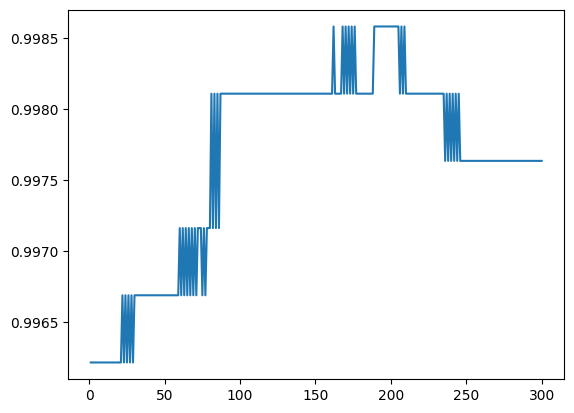

In [45]:
corrects=[0,]*300
for i in range(len(t_lab)):
  g=0
  for j in range(300):
    dim,cut,p,q,alpha=splits2[j]
    alpha=np.log(alpha)
    if(t_data[i][dim]<=cut):
      g+=alpha*p
    else:
      g+=alpha*q
    pred=np.sign(g)

    if pred==t_lab[i]:
      corrects[j]+=1
# print(miss_class)
plt_y=[corrects[i]/len(t_lab) for i in range(300) ]
plt_x=[i+1 for i in range(300)]

max_accu=0
max_idx=-1
for i in range(len(plt_y)):
  if max_accu<plt_y[i]:
    max_idx=i
    max_accu=plt_y[i]
print(max_accu,max_idx)
print(plt_y[65])
plt.plot(np.array(plt_x), np.array(plt_y))
plt.show()

In [42]:
print("Test Accuracy:",accuracy)

Test Accuracy: 65.77068557919621


In [ ]:
print(splits)

[[0, 189.85586681021456, -1, 1, 212.29999999999995], [0, 636.8268391112347, -1, 1, 3.235326976020429], [0, -295.9743906129746, -1, 1, 4.226024748646559], [1, 250.43837259952363, -1, 1, 3.3682011664639333], [2, 275.66982491609133, 1, -1, 3.1384199326526967], [3, -143.08216500548002, -1, 1, 1.9816239351439582], [0, -295.9743906129746, -1, 1, 2.339248181430008], [0, 636.8268391112347, -1, 1, 2.610007745239196], [0, -295.9743906129746, -1, 1, 1.8919691362781383], [1, 479.248000404853, -1, 1, 2.301148046010842], [0, -295.9743906129746, -1, 1, 1.7718669154092062], [2, 131.6304096953083, 1, -1, 1.5878993245853046], [1, 554.1297941552319, -1, 1, 1.6551791821338586], [0, -171.12288564608437, -1, 1, 1.55501876171994], [1, 173.55860515494135, -1, 1, 1.5201835940007358], [2, 347.92273686049975, 1, -1, 1.4219251379887927], [0, 636.8268391112347, -1, 1, 1.4324495473584378], [2, -497.88063783599574, -1, 1, 1.5406395240298498], [0, 636.8268391112347, -1, 1, 1.4255932562777045], [0, -295.9743906129746,

[[0, 189.85586681021456, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 250.43837259952363, -1, 1], [2, 275.66982491609133, 1, -1], [3, -143.08216500548002, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 479.248000404853, -1, 1], [0, -295.9743906129746, -1, 1], [2, 131.6304096953083, 1, -1], [1, 554.1297941552319, -1, 1], [0, -171.12288564608437, -1, 1], [1, 173.55860515494135, -1, 1], [2, 347.92273686049975, 1, -1], [0, 636.8268391112347, -1, 1], [2, -497.88063783599574, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 248.1739679960837, -1, 1], [2, -453.65495213993347, -1, 1], [0, 636.8268391112347, -1, 1], [2, 274.99098328925254, 1, -1], [1, 554.1297941552319, -1, 1], [0, -295.9743906129746, -1, 1], [1, 479.248000404853, -1, 1], [2, -529.7980077430798, -1, 1], [0, 636.8268391112347, -1, 1], [3, 88.02861977638378, 1, -1], [3, -143.08216500548002, -1, 1], [4, 6.20496983595

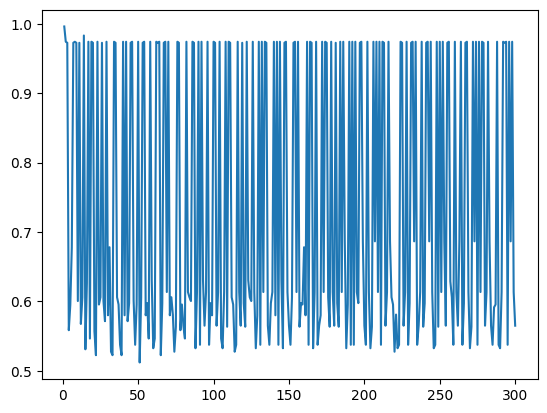

In [ ]:
plt_x=[]
plt_y=[]
print(splits)

print(set(splits[i][0] for i in range(300)))
print(val_data.shape)
best_tree_split=[]
for i in range(300):
  miss_class=0
  dim,cut,p,q=splits[i][0],splits[i][1],splits[i][2],splits[i][3]
  # print(dim)
  for j in range(2000):
    if(val_data[j][dim]>=cut  and val_lab[j]!=q) or (val_data[j][dim]<cut  and val_lab[j]!=p):
      miss_class+=1
  # print(miss_class)
  accuracy=1-(miss_class/2000)
  plt_y.append(accuracy)
  plt_x.append(i+1)
print(plt_y)

plt.plot(np.array(plt_x), np.array(plt_y))
plt.show()

In [ ]:
splits2=[[0, 189.85586681021456, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 250.43837259952363, -1, 1], [2, 275.66982491609133, 1, -1], [3, -143.08216500548002, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 479.248000404853, -1, 1], [0, -295.9743906129746, -1, 1], [2, 131.6304096953083, 1, -1], [1, 554.1297941552319, -1, 1], [0, -171.12288564608437, -1, 1], [1, 173.55860515494135, -1, 1], [2, 347.92273686049975, 1, -1], [0, 636.8268391112347, -1, 1], [2, -497.88063783599574, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 248.1739679960837, -1, 1], [2, -453.65495213993347, -1, 1], [0, 636.8268391112347, -1, 1], [2, 274.99098328925254, 1, -1], [1, 554.1297941552319, -1, 1], [0, -295.9743906129746, -1, 1], [1, 479.248000404853, -1, 1], [2, -529.7980077430798, -1, 1], [0, 636.8268391112347, -1, 1], [3, 88.02861977638378, 1, -1], [3, -143.08216500548002, -1, 1], [4, 6.204969835957179, -1, 1], [2, -453.65495213993347, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 554.1297941552319, -1, 1], [2, 274.99098328925254, 1, -1], [1, 201.6139447337673, -1, 1], [2, -453.65495213993347, -1, 1], [0, 636.8268391112347, -1, 1], [3, 88.02861977638378, 1, -1], [0, 636.8268391112347, -1, 1], [2, -529.7980077430798, -1, 1], [1, 450.23736703980194, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [2, -567.6608705301771, -1, 1], [1, 201.6139447337673, -1, 1], [2, 274.99098328925254, 1, -1], [0, 636.8268391112347, -1, 1], [2, -424.9692876634257, -1, 1], [1, 554.1297941552319, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [3, 88.02861977638378, 1, -1], [1, 450.23736703980194, -1, 1], [2, -497.88063783599574, -1, 1], [0, 636.8268391112347, -1, 1], [2, 371.32898875590104, 1, -1], [1, 177.85598930246456, -1, 1], [2, -497.88063783599574, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [2, -453.65495213993347, -1, 1], [1, 450.23736703980194, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [3, 88.02861977638378, 1, -1], [1, 554.1297941552319, -1, 1], [2, 205.82823532623058, 1, -1], [4, 5.4484609270945015, -1, 1], [2, -518.122566111314, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 250.43837259952363, -1, 1], [2, 274.99098328925254, 1, -1], [1, 732.3939513026887, -1, 1], [2, -497.88063783599574, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [1, 554.1297941552319, -1, 1], [2, -570.957805331773, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 177.85598930246456, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [2, 371.32898875590104, 1, -1], [1, 732.3939513026887, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [1, 450.23736703980194, -1, 1], [3, 88.02861977638378, 1, -1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 732.3939513026887, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [2, -497.88063783599574, -1, 1], [1, 177.85598930246456, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [2, -518.122566111314, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 554.1297941552319, -1, 1], [2, 273.70539682858697, 1, -1], [4, 6.204969835957179, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [1, 732.3939513026887, -1, 1], [0, -295.9743906129746, -1, 1], [1, 450.23736703980194, -1, 1], [2, -518.122566111314, -1, 1], [0, 636.8268391112347, -1, 1], [2, 371.32898875590104, 1, -1], [1, 554.1297941552319, -1, 1], [2, -570.957805331773, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [1, 177.85598930246456, -1, 1], [3, 88.02861977638378, 1, -1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 732.3939513026887, -1, 1], [2, -482.6153684279619, -1, 1], [1, 450.23736703980194, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [3, 88.02861977638378, 1, -1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [2, 366.10112388359556, 1, -1], [1, 177.85598930246456, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [1, 732.3939513026887, -1, 1], [2, -482.6153684279619, -1, 1], [1, 554.1297941552319, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [2, -518.122566111314, -1, 1], [1, 450.23736703980194, -1, 1], [2, 273.70539682858697, 1, -1], [3, -143.08216500548002, -1, 1], [3, 88.02861977638378, 1, -1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 177.85598930246456, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [1, 732.3939513026887, -1, 1], [3, 88.02861977638378, 1, -1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 554.1297941552319, -1, 1], [2, -518.122566111314, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [1, 732.3939513026887, -1, 1], [0, -295.9743906129746, -1, 1], [1, 450.23736703980194, -1, 1], [2, -518.122566111314, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [3, 240.40440333078914, 1, -1], [1, 177.85598930246456, -1, 1], [2, 274.80923027912013, 1, -1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [1, 450.23736703980194, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [3, 240.40440333078914, 1, -1], [1, 732.3939513026887, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [1, 177.85598930246456, -1, 1], [2, -518.122566111314, -1, 1], [0, 636.8268391112347, -1, 1], [3, 240.40440333078914, 1, -1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 732.3939513026887, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [3, 240.40440333078914, 1, -1], [1, 554.1297941552319, -1, 1], [2, 274.80923027912013, 1, -1], [4, 6.204969835957179, -1, 1], [2, 205.82823532623058, 1, -1], [1, 177.85598930246456, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 732.3939513026887, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [1, 450.23736703980194, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [3, 240.40440333078914, 1, -1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [1, 732.3939513026887, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [2, -518.122566111314, -1, 1], [1, 450.23736703980194, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [3, 240.40440333078914, 1, -1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [1, 177.85598930246456, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [2, -518.122566111314, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [3, 240.40440333078914, 1, -1], [1, 732.3939513026887, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [2, 365.37794149688483, 1, -1], [1, 554.1297941552319, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [1, 732.3939513026887, -1, 1], [3, 240.40440333078914, 1, -1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [1, 450.23736703980194, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [1, 177.85598930246456, -1, 1], [2, -518.122566111314, -1, 1], [0, 636.8268391112347, -1, 1], [3, 240.40440333078914, 1, -1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [1, 732.3939513026887, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [3, 240.40440333078914, 1, -1], [1, 732.3939513026887, -1, 1], [2, -482.6153684279619, -1, 1], [1, 407.12404494220687, -1, 1], [2, 274.80923027912013, 1, -1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [1, 177.85598930246456, -1, 1], [3, -587.7303161694949, -1, 1], [0, 636.8268391112347, -1, 1], [0, -295.9743906129746, -1, 1], [0, 636.8268391112347, -1, 1], [2, -482.6153684279619, -1, 1], [0, 636.8268391112347, -1, 1], [3, 240.40440333078914, 1, -1], [0, 636.8268391112347, -1, 1], [3, -587.7303161694949, -1, 1], [1, 732.3939513026887, -1, 1]]


In [ ]:
t_data=[]
t_lab=[]
print(len(t_lab),len(t_data),len(val_lab))

t_data.extend(test_images[test_labels==0])

print(len(t_lab),len(t_data))

t_data.extend(test_images[test_labels == 1])
print(len(t_lab),len(t_data))

# val_data.extend(train_images[train_labels==1][:1000])
t_lab=[-1,]*len(test_labels[test_labels==0]) +[1,]*len(test_labels[test_labels==1])
print(len(t_lab),len(t_data))
t_data=np.array(t_data).reshape(-1,784).T
t_data=t_data-mean
t_data=np.dot(Up,t_data).T
miss_class=0
dim,cut,p,q=splits2[0][0],splits2[0][1],splits2[0][2],splits2[0][3]
# print(dim)
print(t_data.shape,len(t_lab))
for j in range(len(t_lab)):
  if (t_data[j][dim]>=cut  and t_lab[j]!=q) or (t_data[j][dim]<cut  and t_lab[j]!=p):
    miss_class+=1
print(miss_class)
# print(miss_class)
accuracy=1-(miss_class/len(t_lab))

# lab=[-1,]*(len(train_labels[train_labels==0])-1000) + [1,]*(len(train_labels[train_labels==1])-1000)

0 0 2000
0 980
0 2115
2115 2115
(2115, 5) 2115
8


In [ ]:
print(accuracy)

0.9962174940898345


# Q2)**Regression**

In [56]:
data_reg=[]
lab_reg=[]
data_val_reg=[]
lab_val_reg=[]
for i in range(2):
  total_d=train_images[train_labels==i]
  data_reg.extend(total_d[1000:])
  data_val_reg.extend(total_d[:1000])
  lab_reg.extend([i,]*(len(total_d)-1000))
  lab_val_reg.extend([i,]*1000)
data_reg=np.array(data_reg).reshape(-1,784).T

data_val_reg=np.array(data_val_reg).reshape(-1,784).T
N=data_reg.shape[1]
print(N)
Up,mean,data_reg=pca(data_reg,N)
Up=Up[:5]

x=np.dot(Up,data_reg).T
data_val_reg=np.dot(Up,data_val_reg)
print(x.shape)


t_data=[]
t_lab=[]
print(len(t_lab),len(t_data),len(val_lab))

t_data.extend(test_images[test_labels==0])

print(len(t_lab),len(t_data))

t_data.extend(test_images[test_labels == 1])
print(len(t_lab),len(t_data))

# val_data.extend(train_images[train_labels==1][:1000])
t_lab=[-1,]*len(test_labels[test_labels==0]) +[1,]*len(test_labels[test_labels==1])
print(len(t_lab),len(t_data))
t_data=np.array(t_data).reshape(-1,784).T
t_data=t_data-mean
t_data=np.dot(Up,t_data).T

# dim,cut,p,q=splits2[0][0],splits2[0][1],splits2[0][2],splits2[0][3]
# print(dim)
print(t_data.shape,len(t_lab))

10665
(784, 1)
10665
[1022953.1111329617, 291427.0654548821, 257647.89454930546, 178110.0102305892, 125004.85492479337, 110234.36273673267, 74999.92116921129, 66351.32837079643, 56676.978187646266, 50502.96997191876]
1022953.1111329617
(10665, 5)
0 0 2000
0 980
0 2115
2115 2115
(2115, 5) 2115


In [50]:
print(x[0][0],data_val_reg[0][0])

-428.5005133160675 -1766.0199496063433


In [57]:
midpts=[]
classifies=[[],[],[],[],[]]
xT=x.T

for i in range(5):
  values=sorted(list(set(xT[i])))
  print(values[0],values[4000])
  mdpt=[]
  for j in range(len(values)-1):
    mdpt.append((values[j]+values[j+1])/2)

  midpts.append(mdpt)
labls_sorted=[]
for i in range(5):
  values=sorted([(x[j][i],j) for j in range(len(lab))], key=lambda x: x[0])
  labls_sorted.append([j[1] for j in values])
print(midpts)

-2330.829760860835 -619.3674440916103
-1547.143524140316 -172.8612931925561
-1419.4462227153772 -200.80201751775172
-1355.5844903029827 -33.78595653265331
-930.528992293562 -127.52254688134506
[[-2329.0166017597985, -2308.6768045980316, -2284.416267357493, -2267.313411189817, -2247.840204982975, -2236.6425419992297, -2224.9148511199173, -2207.41854108859, -2192.0737825246274, -2179.3411952781507, -2172.077337931367, -2171.057062062857, -2170.456889212587, -2168.163298916138, -2164.934141991003, -2153.7879302017263, -2142.5566798603613, -2135.516048422329, -2128.398510546729, -2120.468988485308, -2112.4001538976418, -2110.0072438854863, -2108.191219768024, -2106.774782878886, -2103.893180844458, -2099.6763735245295, -2093.051170457252, -2085.149326290053, -2079.7400806141213, -2075.382296515064, -2073.651548904406, -2069.3228346151254, -2063.3903936474762, -2060.4746678902256, -2058.3306084310307, -2056.4456969112653, -2054.8123232625103, -2052.9825183956345, -2050.595643592035, -2048.8

In [58]:
def boostRegression(x,y,labls_sorted,splits):
  # print(set(w))
  min_ssr=[np.inf,0,0]
  for i in range(5):
    # partition=partitions[i]
    l_avg=0
    l_s=0
    r_s=sum([y[k] for k in labls_sorted[i]])
    ssrL=0
    r_avg=r_s/len(y)
    ssrR=sum([(y[k]-r_avg)**2 for k in labls_sorted[i]])
    for j in range(len(midpts[i])):

      prev_l=l_avg
      prev_r=r_avg
      l_avg=(l_avg*j+y[labls_sorted[i][j]])/(j+1)
      r_len=len(y)-j
      r_avg=(r_avg*(r_len)-y[labls_sorted[i][j]])/(r_len-1)

      diffL=l_avg-prev_l
      ssrL+=j*(diffL**2) + 2*prev_l*diffL*j -2*diffL*l_s
      diffR=prev_r-r_avg
      ssrR+=r_len*(diffR**2) - 2*prev_r*diffR*r_len + 2*diffR*r_s-((y[labls_sorted[i][j]]-r_avg)**2)

      l_s+=y[labls_sorted[i][j]]
      r_s-=y[labls_sorted[i][j]]

      ssrL+=(y[labls_sorted[i][j]]-l_avg)**2
      ssr=ssrL+ssrR

      if min_ssr[0]>ssr:
        min_ssr=[ssr,0.01*l_avg,0.01*r_avg,i,j]
  l_avg,r_avg,dim,cut=min_ssr[1:]

  for i in range(cut+1):
    y[i]=y[i]-l_avg
  for i in range(cut+1,len(y)):
    y[i]=y[i]-r_avg
  splits.append(min_ssr)
splits=[]
y=[j for j in lab_reg]
print(len(y))
print(labls_sorted)
print(y)
iter=300
for i in range(iter):
#  print(y[0])
 boostRegression(x,y,labls_sorted,splits)
 print(splits[-1])
print(splits)

10665
[[1497, 1263, 3617, 3201, 2373, 1494, 420, 967, 2634, 1499, 2610, 2551, 3026, 3204, 1764, 935, 1167, 1220, 1754, 1759, 100, 922, 4178, 26, 932, 1748, 424, 3551, 1078, 360, 1896, 1715, 3753, 1905, 1317, 1333, 285, 2638, 929, 1176, 1894, 23, 4766, 4440, 618, 2827, 2861, 4491, 2604, 4624, 1315, 4456, 4820, 1525, 1744, 3710, 2032, 176, 2832, 1270, 1416, 4234, 3740, 416, 2499, 4369, 1771, 4251, 1168, 2328, 3205, 3194, 1191, 4237, 4869, 2829, 2915, 4871, 1758, 4771, 435, 1281, 3754, 2470, 3219, 427, 2111, 3632, 1880, 425, 2082, 1815, 90, 356, 905, 4169, 1476, 4588, 1390, 3538, 3195, 4490, 3790, 1504, 971, 120, 624, 2805, 1328, 2989, 1511, 3196, 1571, 295, 3802, 928, 940, 3427, 58, 1502, 411, 4501, 977, 2738, 2685, 1057, 1647, 1375, 1791, 3695, 3217, 1804, 2270, 3760, 1772, 4661, 1469, 917, 3733, 2585, 4873, 4772, 4200, 79, 979, 2547, 1166, 1907, 3665, 4484, 4511, 362, 4183, 2828, 1944, 574, 1182, 4533, 469, 997, 3736, 1812, 2553, 3600, 1789, 36, 4423, 1393, 613, 1332, 1081, 3731, 3713,

In [ ]:
# for i in range(5000):
#  print(i)
#  boostRegression(x,y,labls_sorted,partitions,splits)
#  print(splits[-1])

In [50]:
# print(midpts[0][0],midpts[0][4916])
# data_val_reg=data_val_reg.T


-2329.0166017597985 189.85586681021456


In [69]:
print(len(splits))
iter=len(splits)
print(iter)

15920
15920


In [59]:
data_val_reg=data_val_reg.T

(2000, 5) 2000


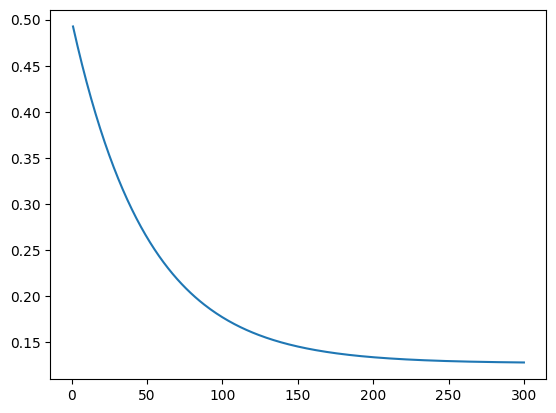

In [60]:
print(data_val_reg.shape,len(lab_val_reg))
mses=[0,]*iter

for i in range(len(lab_val_reg)):
  g=lab_val_reg[i]
  for j in range(iter):
    l_avg,r_avg,dim,cut=splits[j][1:]
    # print(dim,cut,i,len)
    g-=l_avg if data_val_reg[i][dim]<=midpts[dim][cut] else r_avg
    mses[j]+=g**2

for i in range(iter):
  mses[i]/=len(lab_val_reg)
plt.plot(np.array([i+1 for i in range(iter)]),np.array(mses))



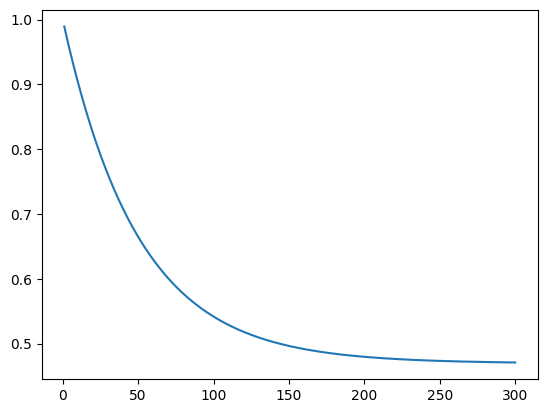

In [61]:
mses=[0,]*iter

for i in range(len(t_lab)):
  g=t_lab[i]
  for j in range(iter):
    l_avg,r_avg,dim,cut=splits[j][1:]
    # print(dim,cut,i,len)
    g-=l_avg if t_data[i][dim]<=midpts[dim][cut] else r_avg
    mses[j]+=g**2

for i in range(iter):
  mses[i]/=len(t_lab)
plt.plot(np.array([i+1 for i in range(iter)]),np.array(mses))

In [62]:
print(mses[-1])

0.4707396729956258


In [59]:
print(mses[4900:5000])

[0.13766207864531269, 0.13766822174592705, 0.13767651456624402, 0.13768146353563449, 0.13768973388470493, 0.13769468292833023, 0.13770083309149164, 0.13770912723170495, 0.13771527470500475, 0.13772143197705933, 0.13772973966203514, 0.13773589423081195, 0.13774416927116548, 0.13774913000995118, 0.13775529304507744, 0.13776359197659613, 0.13776855864739077, 0.13777473013612995, 0.13778305283408593, 0.13778922160894486, 0.1377975115929376, 0.13780248415892016, 0.13780866141407222, 0.13781697530694473, 0.13782195381524656, 0.137830245246394, 0.13783522383247646, 0.13784140820798105, 0.13784972360694472, 0.13785470814367307, 0.13786090100110088, 0.1378692402427003, 0.13787543037841296, 0.13788373685574076, 0.13788872730545995, 0.13789492594981506, 0.13790325641221196, 0.13790825282288646, 0.13791445996305765, 0.1379228142852973, 0.1379290186930872, 0.1379373401813677, 0.13794234251246443, 0.1379485554428857, 0.13795690093394267, 0.13796190923634294, 0.13796813067655553, 0.1379765000451146, 